The following notebook is in development. The goal here is to develop a PyStan model for Kepler 
planet occurrence rates where we can include uncertainties in the completeness contours (basically 
account for stellar uncertainies and planet property uncertainties in the inference of the occurrence rate.
The PyStan softwhere is still in development and debugging is a bit tricky so we are pair coding as a solution 
to this issue.  

First, we are implementng a powerlaw parameterization for planet radius and insolation in order to calculate occurrence rates based off of work by Chris Burke and the open science blog post by Dan Foreman-Mackey: The 
original exopop.ipynb from Dan Foreman-Mackey, is found at http://dan.iel.fm/downloads/notebooks/exopop.ipynb, 
and the accompanying blog post is at http://dan.iel.fm/posts/exopop/

Some parts of this code were developed at the exoplanet population hackathon by Ravi and Joe Catanzarite.

This notebook has been adapted to work in the parameter space of [ insolation , planet radius ] rather than 
[period , planet radius ] for Natalie Batalha's eta Earth project.  

--------------------------------------------------

Wed. Jun 1: @author mshabram and jcatanza
Developing PyStan population model using Stan function block.

8/15/2016
This PyStan model version uses pre-computed completeness as input, for testing and developement.  

8/18/2016
We now have a working version of the power law occurrence rate model using PyStan that agrees with the results from the Burke calculations and the DFM python notebook blog post implementation.  Wahoo.  Now we will add uncertanties into the completeness calculations. 


In [2]:
#%%=========================================================
# Intialize
# Had to put __future__ before other imports
from __future__ import division, print_function
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20
import os
import requests
import pandas as pd
from cStringIO import StringIO

# The following commands are for use in the notebook environment
# Comment them out if this code is to be run in a python or ipython shell
%matplotlib inline
%config InlineBackend.figure_format = "retina"



In [3]:
#%%=========================================================
# This function downloads and caches a dataset from the exoplanet archive
# into a pandas frame
def get_catalog(name, basepath="data"):
    fn = os.path.join(basepath, "{0}.h5".format(name))
    if os.path.exists(fn):
        return pd.read_hdf(fn, name)
    if not os.path.exists(basepath):
        os.makedirs(basepath)
    print("Downloading {0}...".format(name))
    url = ("http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/"
           "nph-nstedAPI?table={0}&select=*").format(name)
    r = requests.get(url)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
    fh = StringIO(r.content)
    df = pd.read_csv(fh)
    df.to_hdf(fn, name, format="t")
    return df
    


In [4]:
#%%=========================================================
# Get the stellar catalog and make selection cuts   
import numpy as np

#!!!!! Q1-Q17 DR 24 (9.2 pipeline)
stlr = get_catalog("q1_q17_dr24_stellar")

#!!!!! Q1-Q16 (9.1 pipeline)
# stlr = get_catalog("q1_q16_stellar")

# !!!!! Select G dwarfs.
# m = (5300 <= stlr.teff) & (stlr.teff <= 6000)

# !!!!! Select K dwarfs.
m = (3900 <= stlr.teff) & (stlr.teff <= 5300)

# !!!!! Select M dwarfs.
# m = (2400 <= stlr.teff) & (stlr.teff <= 3900)

# stellar radius cut
#m &= stlr.radius <= 1.15

# Only include stars with sufficient data coverage:

# Minimum dataspan of 2 years
m &= stlr.dataspan > 365.25*2.

# Minimum dutycycle of 1/2
m &= stlr.dutycycle > 0.50

# Minimum data coverage of 2 years
m &= stlr.dutycycle*stlr.dataspan > 365.25*2.

# minimum rms cdpp at 7.5 hour pulse
#m &= stlr.rrmscdpp07p5 <= 1000.

# Only select stars with mass estimates.
m &= np.isfinite(stlr.mass)

# put selected data into pandas data frame
base_stlr = pd.DataFrame(stlr)
stlr = pd.DataFrame(stlr[m])

print("Selected {0} targets after cuts".format(len(stlr)))


Selected 40685 targets after cuts


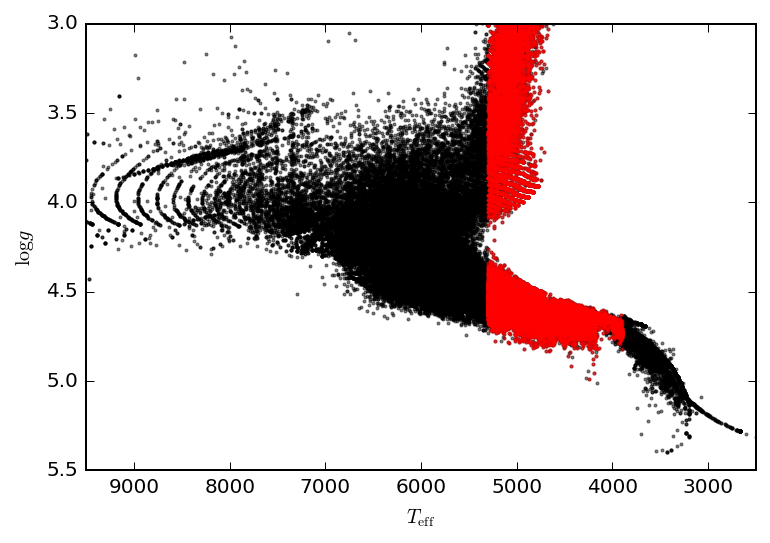

In [5]:
#%%=========================================================
# Plot an HR diagram of the selected targets
import matplotlib.pyplot as pl

pl.plot(base_stlr.teff, base_stlr.logg, ".k", ms=3, alpha=0.5)
pl.plot(stlr.teff, stlr.logg, ".r", ms=3, alpha=0.5)
pl.xlim(9500, 2500)
pl.ylim(5.5, 3)
pl.ylabel("$\log g$");
pl.xlabel("$T_\mathrm{eff}$");


In [6]:
#%%=========================================================

# !!!!! Get the planet catalog and make selection cuts 

# !!!!! Q1-Q17 DR24 (9.2 pipeline)
kois = get_catalog("q1_q17_dr24_koi")

# !!!!! Q1-Q16 planet catalog (9.1 pipeline)
# kois = get_catalog("q1_q16_koi")

# Set insolation and planet radius ranges
# period_rng = (20, 320)
rp_rng = (0.75, 2.5)
insolation_rng = (0.2, 20)

# Join on the stellar list.
kois = pd.merge(kois, stlr[["kepid"]], on="kepid", how="inner")

# Only select the KOIs in the relevant part of parameter space.
m = kois.koi_pdisposition == "CANDIDATE"
base_kois = pd.DataFrame(kois[m])

# Select insolation range instead of period range
m &= (insolation_rng[0] <= kois.koi_insol) & (kois.koi_insol <= insolation_rng[1])
# m &= (period_rng[0] <= kois.koi_period) & (kois.koi_period <= period_rng[1])

m &= np.isfinite(kois.koi_prad) & (rp_rng[0] <= kois.koi_prad) & (kois.koi_prad <= rp_rng[1])

# !!!!! Only include PCs with MES > 15 for 9.2 (Q1-Q17 Dr24)
m &= kois.koi_max_mult_ev > 15
# !!!!! Comment out above statement for 9.1 (Q1-Q16) -- Note all max_mult_ev seem to be NaNs anyyway

# Panda data frame for selected kois
# Note that kois now contains only the selected planet candidates
kois = pd.DataFrame(kois[m])

#print("min insolation = {0} ".format(np.min((kois.koi_insol))))
#print("max insolation = {0} ".format(np.max((kois.koi_insol))))
#print(kois.koi_insol)


#print("min period = {0} ".format(np.min(kois.koi_period)))
#print("max period = {0} ".format(np.max(kois.koi_period)))
#print("Selected {0} KOIs after cuts".format(len(kois)))


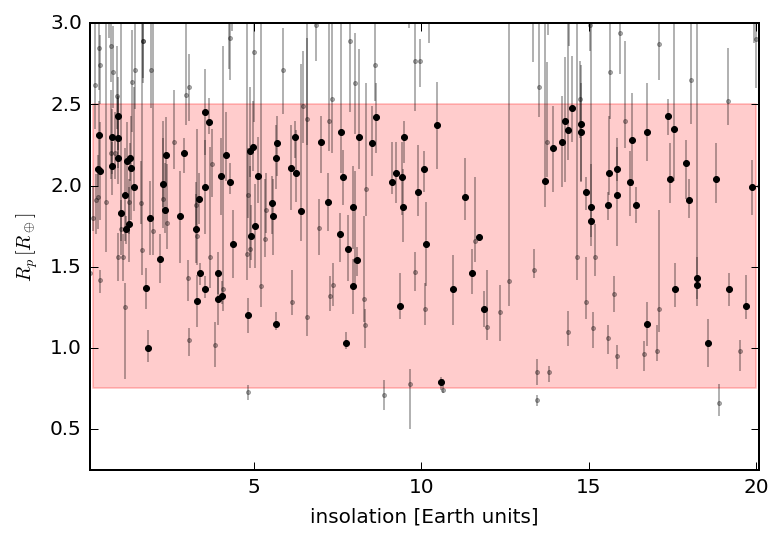

In [7]:
#%%=========================================================
# Plot the measurements with error bars, in insolation-radius parameter space
yerr = np.abs(np.array(base_kois[["koi_prad_err2", "koi_prad_err1"]])).T
pl.errorbar(base_kois.koi_insol, base_kois.koi_prad, yerr=yerr, fmt=".k", ms=4,
            capsize=0, alpha=0.3)
pl.plot(kois.koi_insol, kois.koi_prad, ".k", ms=6)
pl.fill_between(insolation_rng, [rp_rng[1], rp_rng[1]], [rp_rng[0], rp_rng[0]], color="r", alpha=0.2)
pl.xlim(insolation_rng + 0.1 * np.array([-1, 1]))
pl.ylim(rp_rng + 0.5 * np.array([-1, 1]))
pl.xlabel("insolation [Earth units]")
pl.ylabel("$R_p \, [R_\oplus]$");


In [8]:
#%%=========================================================
# Completeness model helper functions (radius and orbital period)

from scipy.stats import gamma

def get_duration(period, aor, e):
    """
    Equation (1) from Burke et al. This estimates the transit
    duration in the same units as the input period. There is a
    typo in the paper (24/4 = 6 != 4).
    
    :param period: the period in any units of your choosing
    :param aor:    the dimensionless semi-major axis (scaled
                   by the stellar radius)
    :param e:      the eccentricity of the orbit
    
    """
    return 0.25 * period * np.sqrt(1 - e**2) / aor

def get_a(period, mstar, Go4pi=2945.4625385377644/(4*np.pi*np.pi)):
    """
    Compute the semi-major axis of an orbit in Solar radii.
    
    :param period: the period in days
    :param mstar:  the stellar mass in Solar masses
    
    """
    return (Go4pi*period*period*mstar) ** (1./3)

def get_delta(k, c=1.0874, s=1.0187):
    """
    Estimate the approximate expected transit depth as a function
    of radius ratio. There might be a typo here. In the paper it
    uses c + s*k but in the public code, it is c - s*k:
    https://github.com/christopherburke/KeplerPORTs
    
    :param k: the dimensionless radius ratio between the planet and
              the star
    
    """
    delta_max = k*k * (c + s*k)
    
    # !!!!! For Q1-Q16 (9.1 pipeline) DFM used a multiplier 0f 0.84 instead of 1.0 in the equation below
    # return 0.84*delta_max
    
    # !!!!! for Q1-Q17 DR24 (9.2 pipeline), use a multiplier of 1 ????? Ask Chris
    return 1.0* delta_max

# 14 pulse durations
cdpp_cols = [k for k in stlr.keys() if k.startswith("rrmscdpp")]
cdpp_vals = np.array([k[-4:].replace("p", ".") for k in cdpp_cols], dtype=float)

def get_mes(star, period, rp, tau, re=0.009171):
    """
    Estimate the multiple event statistic value for a transit.
    
    :param star:   a pandas row giving the stellar properties
    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param tau:    the transit duration in hours
    
    """
    # Interpolate the RMS CDPP corresponding to the transit duration.
    cdpp = np.array(star[cdpp_cols], dtype=float)
    sigma = np.interp(tau, cdpp_vals, cdpp)

    # Compute the radius ratio and estimate the S/N.
    k = rp * re / star.radius
    snr = get_delta(k) * 1e6 / sigma
    
    # Scale by the estimated number of transits.
    ntrn = star.dataspan * star.dutycycle / period 
    return snr * np.sqrt(ntrn)

# Pre-compute and freeze the gamma function from Equation (5) in
# Burke et al.

# !!!!! Q1-Q16 (9.1 pipeline): DFM used the parameters below
# pgam = gamma(4.65, loc=0., scale=0.98)
# !!!!! But the parameters for FGK are (4.35, 0, 1.05) according to astro-ph 1507.05097 (Christiansen)
# pgam = gamma(4.35, loc=0., scale=1.05)

# !!!!! Parameters for 9.2 pipeline Q1-Q17 DR24 are from Jessie Christiansen
# !!!!! Note that these parameters do not apply to M stars!
pgam = gamma(103.0113, loc=0., scale=0.10583)

# mesthres_cols are column names for the 14 pulse durations
mesthres_cols = [k for k in stlr.keys() if k.startswith("mesthres")]

# pulse_durations_obs are the 14 pulse durations
pulse_durations_obs = np.array([k[-4:].replace("p", ".") for k in mesthres_cols],
                         dtype=float)
def get_pdet(star, aor, period, rp, e):
    """
    Equation (5) from Burke et al. Estimate the detection efficiency
    for a transit.
    
    :param star:   a pandas row giving the stellar properties
    :param aor:    the dimensionless semi-major axis (scaled
                   by the stellar radius)
    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param e:      the orbital eccentricity
    
    """
    # mest is the interpolated MES threshold corresponding to the transit duration
    # tau is the pulse duration
    # pulse_durations_obs are the 14 pulse durations
    # np.array(star[mesthres_cols],dtype=float) are the coresponding MES thresholds
    tau = get_duration(period, aor, e) * 24.
    mes = get_mes(star, period, rp, tau)
    mest = np.interp(tau, pulse_durations_obs,
                     np.array(star[mesthres_cols],
                              dtype=float))
    x = mes - 4.1 - (mest - 7.1)
    
    # !!!!! DFM originally used no multiplier in the equation below;
    # The multiplier of 0.78442 must be a 'plateau factor' from Jessie, for 9.2
    # for the 9.2 Q1-Q17 DR24 data, provided by Jessie
    return 0.78442*pgam.cdf(x)

    # !!!!! For the 9.1 data
    # return pgam.cdf(x)

def get_pwin(star, period):
    """
    Equation (6) from Burke et al. Estimates the window function
    using a binomial distribution.
    
    :param star:   a pandas row giving the stellar properties
    :param period: the period in days
    
    """
    M = star.dataspan / period
    f = star.dutycycle
    omf = 1.0 - f
    pw = 1 - omf**M - M*f*omf**(M-1) - 0.5*M*(M-1)*f*f*omf**(M-2)
    msk = (pw >= 0.0) * (M >= 2.0)
    return pw * msk

def get_pgeom(aor, e):
    """
    The geometric transit probability.
    
    See e.g. Kipping (2014) for the eccentricity factor
    http://arxiv.org/abs/1408.1393
    
    :param aor: the dimensionless semi-major axis (scaled
                by the stellar radius)
    :param e:   the orbital eccentricity

    """
    return 1. / (aor * (1 - e*e)) * (aor > 1.0)


    


 


In [9]:
#================================================================================================
#%% This cell contains functions and code for calculating completeness in the
#       parameter space of [ insolation , planet radius ] 
    
def get_completeness(star, period, rp, e, with_geom=True):
    """
    A helper function to combine all the completeness effects.
    
    :param star:      a pandas row giving the stellar properties (each row is for one star)
    :param period:    the period in days 
    :param rp:        the planet radius in Earth radii
    :param e:         the orbital eccentricity
    :param with_geom: include the geometric transit probability?
    
    """
    aor = get_a(period, star.mass) / star.radius
    pdet = get_pdet(star, aor, period, rp, e)
    pwin = get_pwin(star, period)
    if not with_geom:
        return pdet * pwin
    pgeom = get_pgeom(aor, e)
    return pdet * pwin * pgeom
    print(len(rp))
# Construct grid for planet radius
rp2 = np.linspace(rp_rng[0], rp_rng[1], 61)

# Construct grid for insolation
insolation = np.linspace(insolation_rng[0], insolation_rng[1], 57)
#insolation_grid, rp_grid2 = np.meshgrid(insolation, rp2, indexing="xy")
insolation_grid, rp_grid2 = np.meshgrid(insolation, rp2, indexing="ij")


    
#def get_completeness_from_insolation(star,  rp_grid2, insolation_grid, e, with_geom=True):
def get_completeness_from_insolation(star, insolation_grid, rp_grid2, e, with_geom=True):
    
    # compute the periods corresponding to an insolation grid
    insolation = insolation_grid
    period_grid = get_period_from_insolation( star , insolation )
    
    # completeness 
    completeness = get_completeness(star, period_grid, rp_grid2, e, with_geom=True)
    
    return completeness
    

# Add a function to compute insolation on the period grid, for a given star 
def get_insolation_from_period( star , period ):
    
    # Get needed stellar parameters
    teffStar = star.teff
    teffSun = 5777
    rStar = star.radius
    mStar = star.mass
    
    # Semimajor axis of planet in AU
    aPlanet = mStar**(1.0/3.0) * (period/365.25)**(2.0/3.0) 
    
    # Compute insolation
    insolation = (teffStar/teffSun)**4*(rStar/1)**2*(1/aPlanet)**2
    
    return insolation
    
def get_period_from_insolation( star , insolation ):
    
    # Get needed stellar parameters
    teffStar = star.teff
    teffSun = 5777
    rStar = star.radius
    mStar = star.mass
    
    # Get semimajor axis from star properties and insolation, using
    # insolation = ( teffStar / teffSun )**4 * ( rStar / 1)**2 * ( 1 / aPlanet )**2
    aPlanet = ( ( teffStar / teffSun )**4 * ( rStar / 1)**2 / insolation )**(0.5)
    
    # Get orbit period in days from semimajor axis of planet in AU and start properties, using
    # aPlanet = mStar**(1.0/3.0) * (period/365.25)**(2.0/3.0)
    period = 365.25 * ( aPlanet/( mStar**(1.0/3.0) ) )**(3.0/2.0)
    
    return period



In [10]:
#%%==============================================================================================
# Test: compute completeness grid in [ insolation , planet radius ] 
# parameter space for the first star in the catalog
# new_completeness_grid_single_star = get_completeness_from_insolation(stlr.iloc[0], insolation_grid, rp_grid2, 0.0, with_geom=True)

# Marginalize detection contours over all selected targets
# including the geometric factor. This takes a few minutes.
new_completeness = np.zeros_like(insolation_grid)
for _, star in stlr.iterrows():
    new_completeness += get_completeness_from_insolation(star, insolation_grid, rp_grid2, 0.0, with_geom=True)
    #new_completeness += get_completeness_from_insolation(star, rp_grid2, insolation_grid, 0.0, with_geom=True)



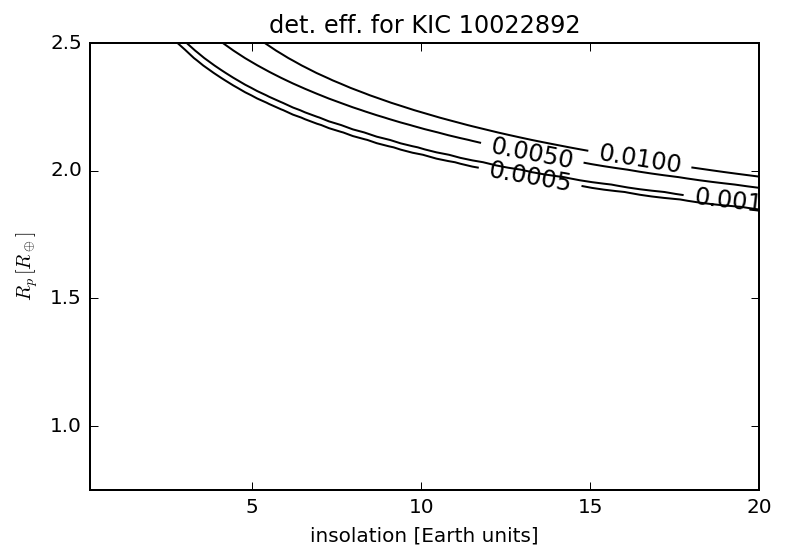

In [11]:
#%%=========================================================
# Reproducing Figure 1 from Burke paper, which is the
# completeness contour (not including geometric effect) for an example target
 
# Repeating for new insolation completeness.  
    
# Choose the first star
# star = stlr[stlr.kepid == 10593626].iloc[0]
# First M star
#star = stlr[stlr.kepid == 10031707].iloc[0]
star = stlr[stlr.kepid == stlr.kepid.iloc[0]].iloc[0]

# Compute the completeness map on a grid.
X, Y = insolation_grid, rp_grid2, 
Z = get_completeness_from_insolation(star, X, Y, 0.0, with_geom=False)

# Plot with the same contour levels as the figure. Add some contours at low end of completeness.
c = pl.contour(X, Y, Z, [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99], colors="k")
pl.clabel(c, fontsize=12, inline=1, fmt="%.4f") 
pl.xlabel("insolation [Earth units]")
pl.ylabel("$R_p \, [R_\oplus]$")
pl.title("det. eff. for KIC {0}".format(np.min(stlr.kepid.iloc[0])));


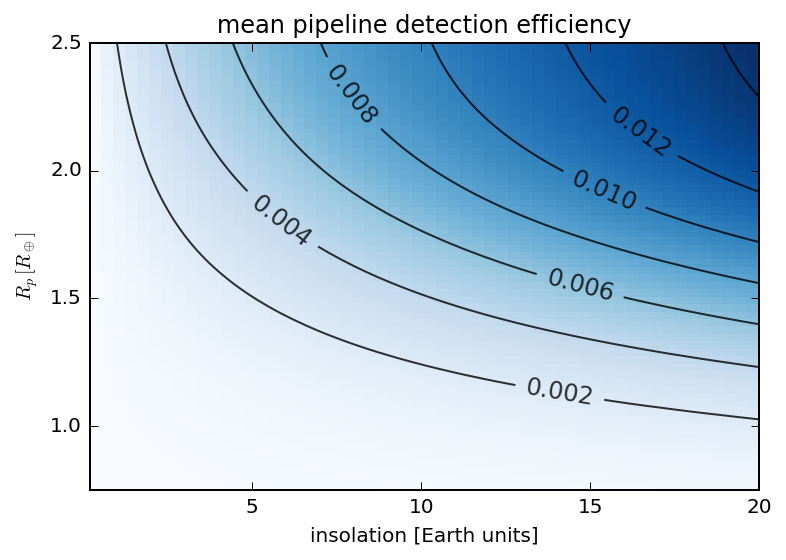

In [12]:
#%%=========================================================
# Plot the average new_completeness contour (radius-insolation)
# Include the geometric effect
pl.pcolor(insolation_grid, rp_grid2, new_completeness, cmap="Blues")
c = pl.contour(insolation_grid, rp_grid2, new_completeness / len(stlr),
               colors="k", alpha=0.8)
pl.clabel(c, fontsize=12, inline=1, fmt="%.3f")
pl.title("mean pipeline detection efficiency")
pl.xlabel("insolation [Earth units]")
pl.ylabel("$R_p \, [R_\oplus]$");


In [13]:
#%%=========================================================
# Population inference with an independent power law model
# Using modified code above that computes 
# completeness in the parameter space of [ insolation , planet radius ], 

# A double power law model for the population.
def population_model_insolation(theta, insolation, rp):
    # Parameters 
    # lnf0 is normalization, 
    # beta is exponent of insolation power law,
    # alpha is exponent of radius power law
    lnf0, beta, alpha = theta
    v = np.exp(lnf0) * np.ones_like(insolation)
    for x, rng, n in zip((insolation, rp),
                         (insolation_rng, rp_rng),
                         (beta, alpha)):
        n1 = n + 1
        v *= x**n*n1 / (rng[1]**n1-rng[0]**n1)
    return v

# The ln-likelihood function given at the top of this post.
# change to insolation from planet catalog

# Insolation and radius for planets in catalog
# koi_periods = np.array(kois.koi_period)
koi_insolation = np.array(kois.koi_insol)
koi_rps = np.array(kois.koi_prad)

# Parameter space volume in each bin of [insolation, radius] grid
# Note the bins are not uniformly spaced in insolation
vol = np.diff(insolation_grid, axis=0)[:, :-1] * np.diff(rp_grid2, axis=1)[:-1, :]
def lnlike(theta):
    pop = population_model_insolation(theta, insolation_grid, rp_grid2) * new_completeness
    pop = 0.5 * (pop[:-1, :-1] + pop[1:, 1:])
    norm = np.sum(pop * vol)
    #print(norm)
    ll = np.sum(np.log(population_model_insolation(theta, koi_insolation, koi_rps))) - norm
    return ll if np.isfinite(ll) else -np.inf
# The ln-probability function is just proportional to the ln-likelihood
# since we're assuming uniform priors.
bounds = [(-5, 5), (-5, 5), (-5, 5)]
def lnprob(theta):
    # Broad uniform priors.
    for t, rng in zip(theta, bounds):
        if not rng[0] < t < rng[1]:
            return -np.inf
    return lnlike(theta)

# The negative ln-likelihood is useful for optimization.
# Optimizers want to *minimize* your function.
def nll(theta):
    ll = lnlike(theta)
    return -ll if np.isfinite(ll) else 1e15



In [14]:
#%%=========================================================
# Maximum likelihood solution by minimizing negative log-likelihood
from scipy.optimize import minimize
# Initial guess for logF, beta, and alpha
theta_0 = np.array([1, 0.66, -1.5])

r = minimize(nll, theta_0, method="L-BFGS-B", bounds=bounds)
print(r)
# r.x is the vector of parameters (logF, beta, and alpha) from the maximum likelihood solution


      fun: 532.02713091922919
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -5.68434189e-05,  -1.13686838e-04,  -4.54747351e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 52
      nit: 10
   status: 0
  success: True
        x: array([ 0.77440222, -1.18780177, -0.97610962])


In [15]:
#%%=========================================================
# Plot the maximum likelihood solution

# We'll reuse these functions to plot all of our results.

# This function plots the density of samples of a double power law,
# as a function of the x0 input, marginalized over the y input
def make_plot(pop_comp, x0, x, y, ax):
    # pop_comp is a two-dimensional array of completeness values
    # pop_comp.shape is 57(insolation) x 61(radius)  
    # x0 is: bin edges of second variable (radius), for model fitting
    # x is rebinning of x0 into a coarser grid for the plots
    # y is: bin edges of first variable (insolation), for model fitting
    # Mid-bin values of the 2D array pop_comp, along the first dimension -- insolation
    pop = 0.5 * (pop_comp[:, 1:] + pop_comp[:, :-1])
    # on first call, pop is 56 x 61

    # Integrate completeness over the first variable, y, insolation
    # np.diff(y)[None, :, None] is the parameter space interval in y
    pop = np.sum(pop * np.diff(y)[None, :, None], axis=1)
    # After above command, pop is 1D, collapsed onto the radius dimension
    
    # Credible regions in x: radius
    # x is used only to get the parameter space interval dx in radius for the plot
    # Note: Assumes bin spacing np.diff(x) is uniform
    a, b, c, d, e = np.percentile(pop * np.diff(x)[0], [2.5, 16, 50, 84, 97.5], axis=0)
    # print(c)

    ax.fill_between(x0, a, e, color="k", alpha=0.1, edgecolor="none")
    ax.fill_between(x0, b, d, color="k", alpha=0.3, edgecolor="none")
    # c is the median value of the distribution over 
    ax.plot(x0, c, "k", lw=1)

def plot_results(samples):
    # Loop through the samples and compute the list of population models.
    samples = np.atleast_2d(samples)
    
    # print(samples.shape)
    # print(len(samples))
    # len(samples) is the length of the MCMC chain
    pop = np.empty((len(samples), insolation_grid.shape[0], insolation_grid.shape[1]))
    gamma_earth = np.empty((len(samples)))
    for i, p in enumerate(samples):
        # insolation_grid and rp_grid2 are meshgrids, 57x61
        # print(p)
        # print(rp_grid2.shape)
        # print(insolation_grid.shape)
        # print(i)
        # power law planet density on insolation, radius grid
        pop[i] = population_model_insolation(p, insolation_grid, rp_grid2)
        # planet density at the point corresponding to earth (insolation = 1 and radius = 1)
        gamma_earth[i] = population_model_insolation(p, 1.0, 1.0) * 1.0
        # print(gamma_earth[i])
        
    # Set up 4x4 grid of plots
    fig, axes = pl.subplots(2, 2, figsize=(10, 8))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    
    # Histogram of planet radius over a new grid
    # Using a coarser grid for the plot
    dx = 5*(rp2[1] - rp2[0])
    x = np.arange(rp_rng[0], rp_rng[1] + dx, dx)
    n, _ = np.histogram(koi_rps, x)
    
    # Plot the predicted radius distribution against the observed radius distribution
    ax = axes[0, 0]
    
    # Predicted radius distribution
    # rp2 is of length 61
    # nsolation is of length 57
    # pop is 57 x 61 -- so it's insolation x radius
    # new_completeness is 1 x 57 x 61
    make_plot(pop * new_completeness[None, :, :], rp2, x, insolation, ax)
    
    # Observed radius distribution, with Poisson errors
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    ax.set_xlim(rp_rng[0], rp_rng[1])
    ax.set_xlabel("$R_p\,[R_\oplus]$")
    ax.set_ylabel("# of detected planets")
    
    # Plot the true radius distribution.
    ax = axes[0, 1]
    make_plot(pop, rp2, x, insolation, ax)
    ax.set_xlim(rp_rng[0], rp_rng[1])
    # ax.set_ylim(0, 0.37)
    ax.set_xlabel("$R_p\,[R_\oplus]$")
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}R$; $\Delta R = 0.25\,R_\oplus$")
    
    # Histogram of insolation over a new grid.
    # Using a coarser grid for the plot
    dx = 5*(insolation[1] - insolation[0])
    
    x = np.arange(insolation_rng[0], insolation_rng[1] + dx, dx)
    n, _ = np.histogram(koi_insolation, x)
    
    # Plot the predicted insolation distribution against the observed insolation distribution
    ax = axes[1, 0]
    
    # Predicted insolation distribution
    make_plot(np.swapaxes(pop * new_completeness[None, :, :], 1, 2), insolation, x, rp2, ax)
    
    # Observed insolation distribution, with Poisson errors
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    # ax.set_xlim(insolation_rng[0], insolation_rng[1])
    ax.set_xlim(0.5, insolation_rng[1])
    ax.set_ylim(0, 25)
    ax.set_xlabel("insolation, [Earth units]")
    ax.set_ylabel("# of detected planets")
    
    # Plot the true insolation distribution.
    ax = axes[1, 1]
    make_plot(np.swapaxes(pop, 1, 2), insolation, x, rp2, ax)
    ax.set_xlim(insolation_rng[0], insolation_rng[1])
    ax.set_xlabel("insolation, [Earth units]")
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}I$; $\Delta I = $")
    
    return gamma_earth



[ 0.42880752]


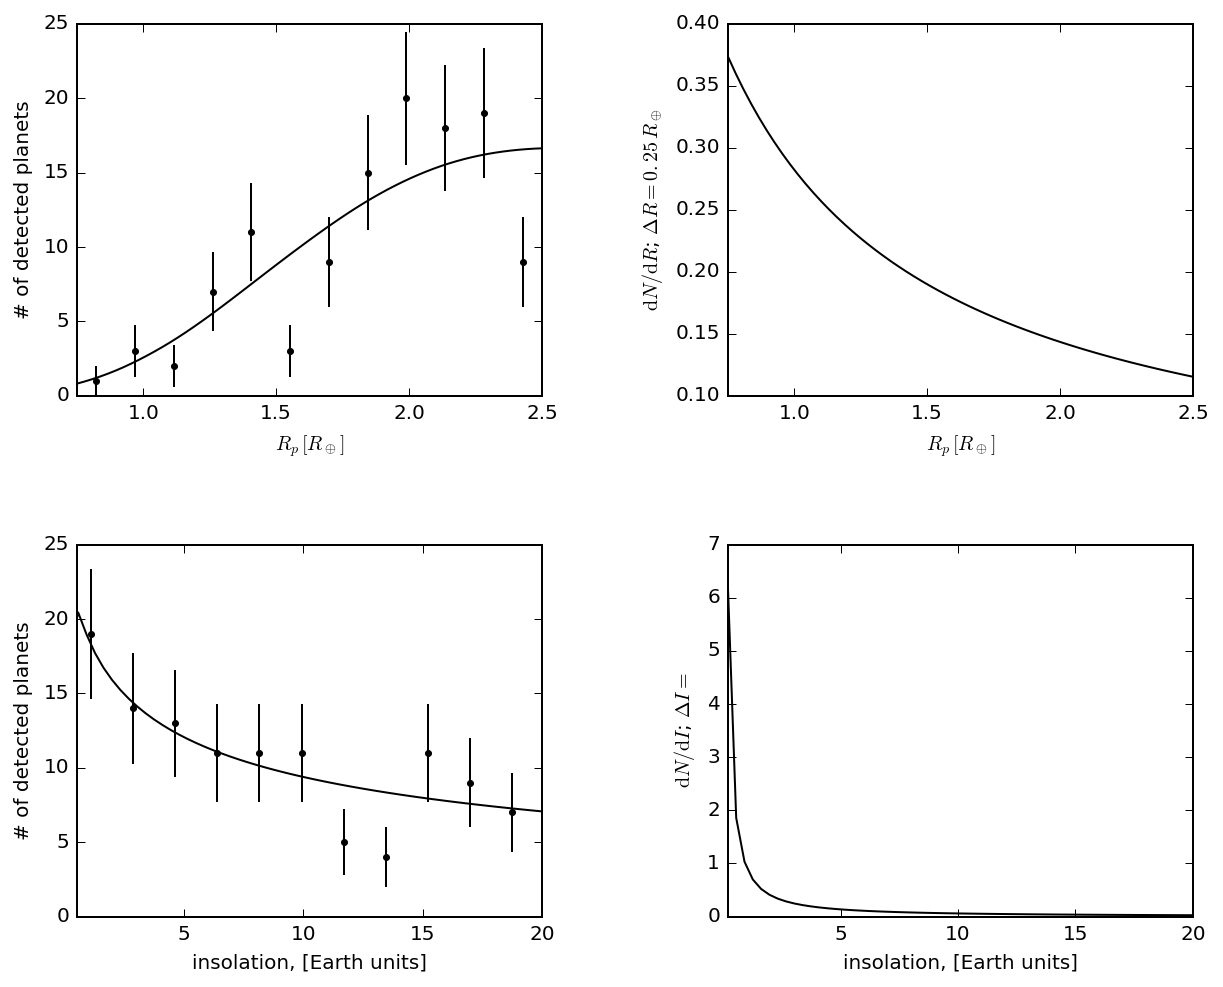

In [16]:
#%%=========================================================

# This line calls all the plotting machinery above, and returns the maximum likelihood value of gamma_earth
# Note that r.x is the set of parameters [ lnf0, beta, alpha ] returned by the maximum likelihood fit
print(plot_results(r.x));

# Or, try your own values for the parameters
# thetaTry = np.array([.01, -1.2, -1.1])
# print(plot_results(thetaTry));

In [17]:
#%%=========================================================
# Sample from the posterior probability distribution for the population parameters using emcee
import emcee

ndim, nwalkers = len(r.x), 16
pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# Burn in.
pos, _, _ = sampler.run_mcmc(pos, 1000)
sampler.reset()

# Production.
pos, _, _ = sampler.run_mcmc(pos, 4000)



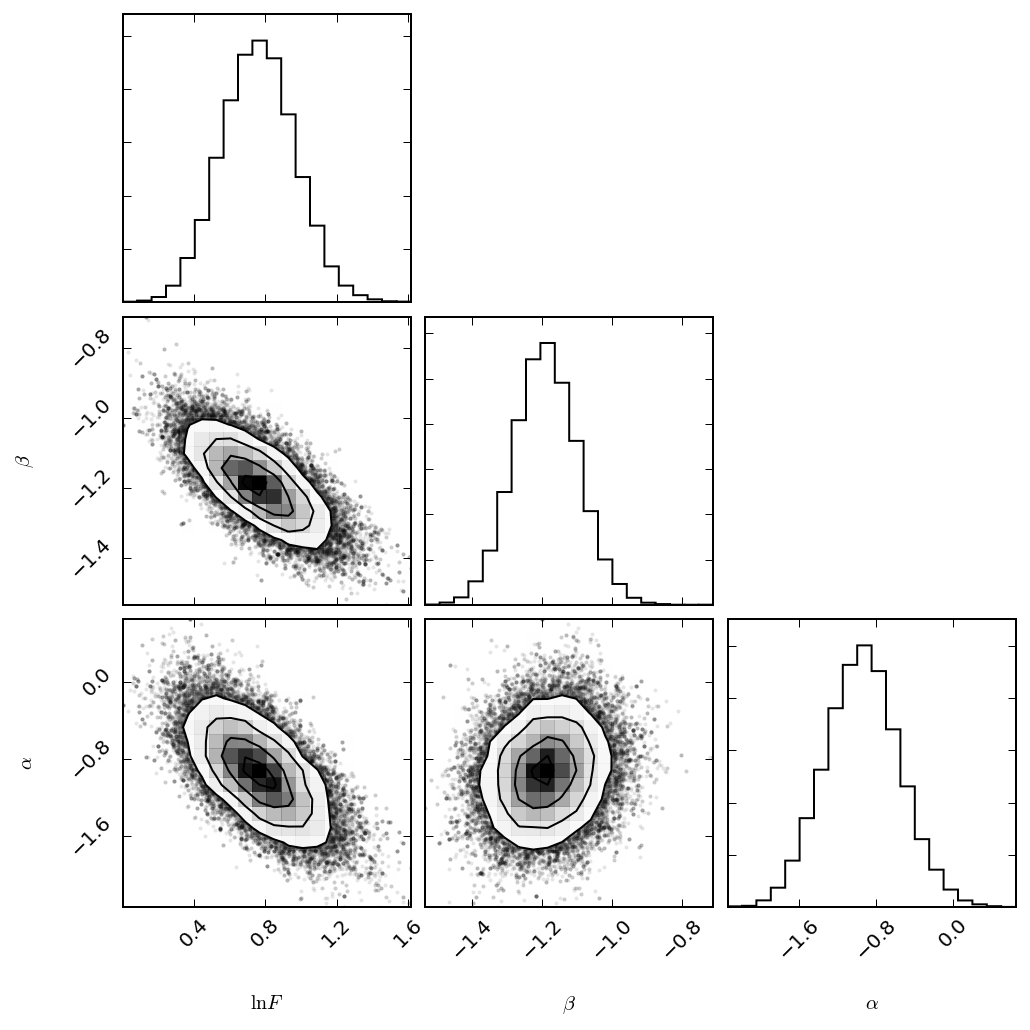

In [18]:
#%%=========================================================
# Triangle plot of PDFs using DFMs corner package
import corner
corner.corner(sampler.flatchain, labels=[r"$\ln F$", r"$\beta$", r"$\alpha$"]);


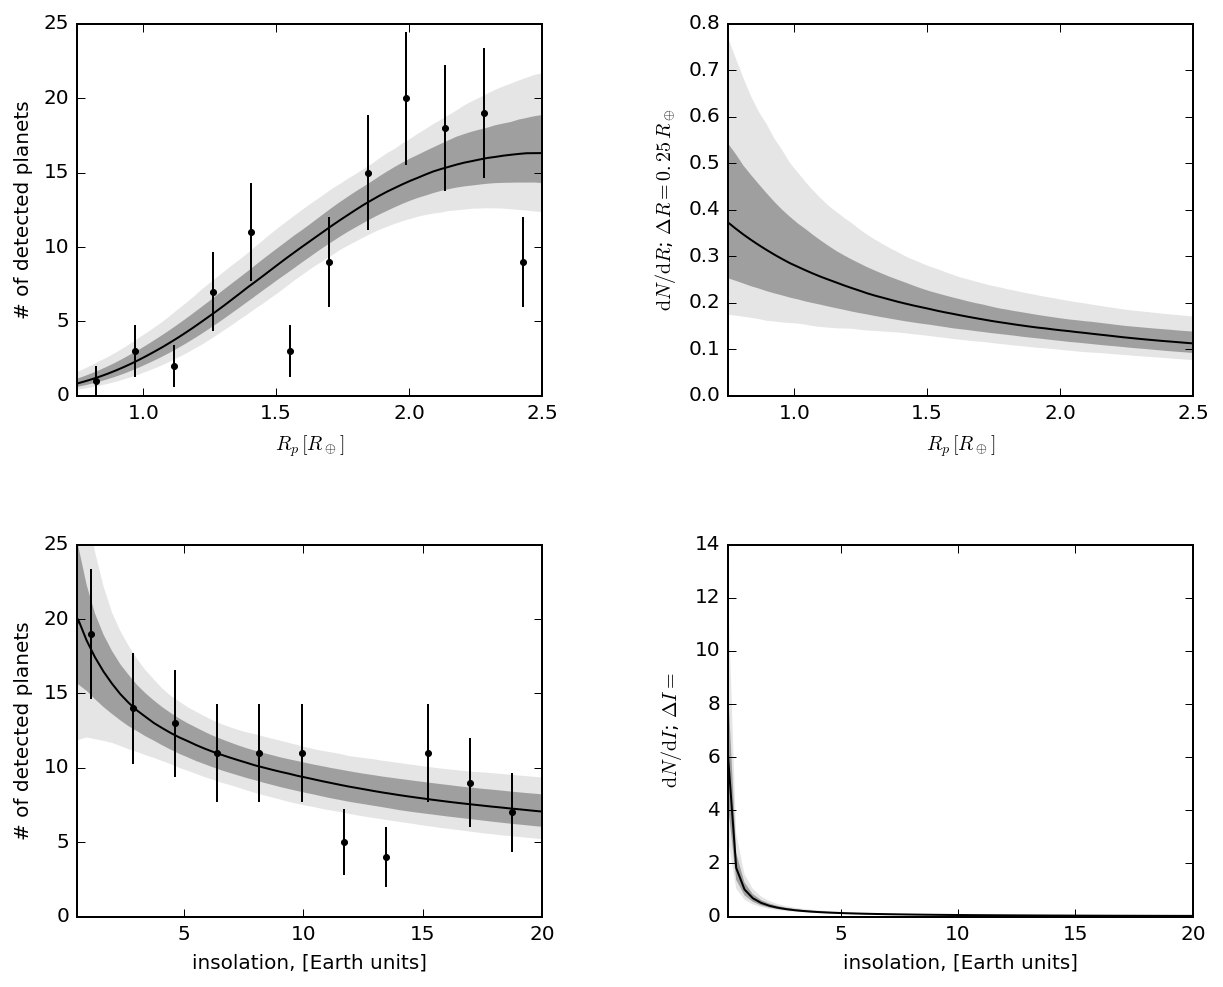

In [19]:
#%%=========================================================
# Plot marginalized posteriors of N and dN/dR
# For Rp, marginalize over P
# For P, marginalize over Rp
# For N, plot also the data and the error bars

# Problem -- plotting all the chains maxes out my PCs memory.    
# Solution -- plot only the last 4000 chains 
gamma_earth = plot_results(sampler.flatchain[60000:63999,:])


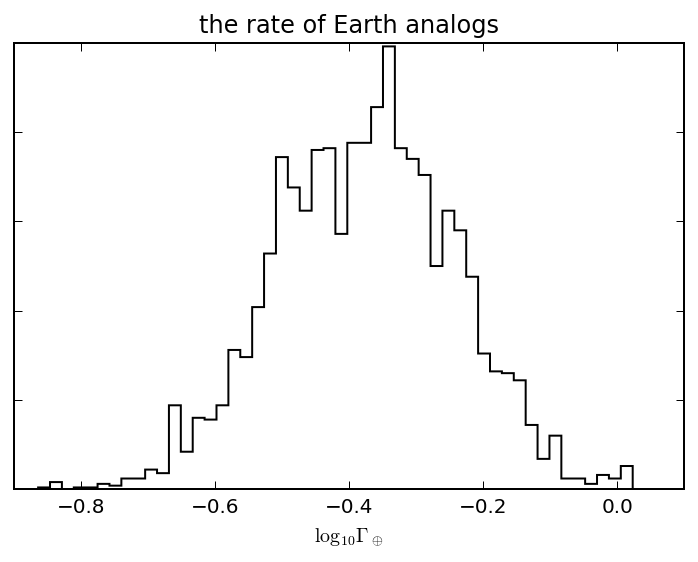

In [20]:
#%%=========================================================
# Plot the PDF of gamma_earth
pl.hist(np.log10(gamma_earth), 50, histtype="step", color="k")
pl.gca().set_yticklabels([])
pl.title("the rate of Earth analogs")
pl.xlabel(r"$\log_{10}\Gamma_\oplus $");
#pl.xlabel(r"$\log_{10}\Gamma_\oplus = \left. \log_{10}\mathrm{d}^2 N / \mathrm{d} Insolation \, \mathrm{d} R_p \right |_\oplus$");




16, 50, 84 percentile range for integrated gamma = [ 0.31905463  0.42887092  0.56677993] 


<function matplotlib.pyplot.xticks>

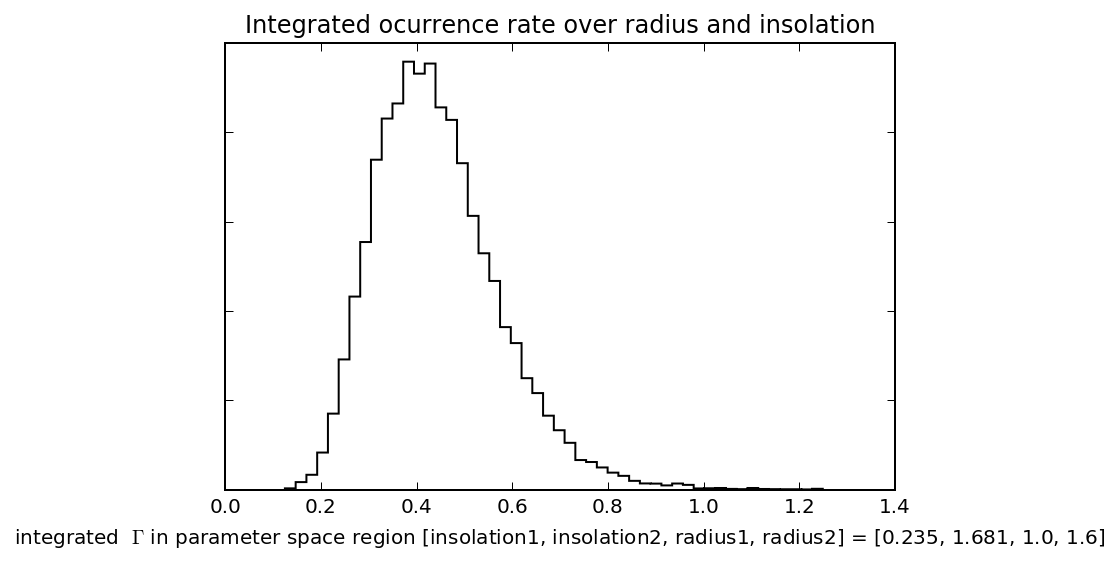

In [21]:
#%%=========================================================
# Integrate the planet density over a given range in insolation and radius
#   to get the exoplanet occurrence rate predicted by the power law in that region
def integrated_gamma(theta,insolation1,insolation2,radius1,radius2):
    lnf0, beta, alpha = theta
    
    # Parameter Space Boundaries for our model
    insol_rng = (0.2, 20)
    radius_rng = (0.75, 2.5)
    
    # Compute exoplanet occurrence rate integrated over chosen region of [ insolation , radius] parameter space
    integral_over_insolation = (insolation2**(beta + 1) - insolation1**(beta + 1))/(insol_rng[1]**(beta + 1) - insol_rng[0]**(beta + 1))
    integral_over_radius = (radius2**(alpha + 1) - radius1**(alpha + 1))/(radius_rng[1]**(alpha + 1) - radius_rng[0]**(alpha + 1))
    eta = integral_over_insolation*integral_over_radius*np.exp(lnf0)
    
    return eta
    

#%% Compute and plot the posterior PDF for the exoplanet occurence rate in a 
#   desired region of period, radius parameter space

# Initialize   
int_gamma_samples = np.empty(len(sampler.flatchain))

# !!!!! Choose insolation limits according to stellar type

# Select G dwarfs
# insolation1 = 0.295
# insolation2 = 1.824

# Select K dwarfs
insolation1 = 0.235
insolation2 = 1.681

# Select M dwarfs
# insolation1 = 0.205
# insolation2 = 1.514

# !!!!! Choose radius limits
radius1 = 1.0
radius2 = 1.6

for i, theta in enumerate(sampler.flatchain):
    int_gamma_samples[i] = integrated_gamma(theta,insolation1,insolation2,radius1,radius2)

# print result for this parameter space region
print("16, 50, 84 percentile range for integrated gamma = {0} ".format(np.percentile(int_gamma_samples,[16,50,84])))

             
# Plot the posterior of int gamma_samples over selected planet radius and period range             
pl.hist(int_gamma_samples, 50, histtype="step", color="k")
pl.gca().set_yticklabels([])
pl.title("Integrated ocurrence rate over radius and insolation")
pl.xlabel(r"integrated  $\Gamma$ in parameter space region [insolation1, insolation2, radius1, radius2] = {0}".format([insolation1,insolation2,radius1,radius2]));
# pl.xlabel(r"$\log_{10}\Gamma_\oplus = \left. \log_{10}\mathrm{d}N / \mathrm{d}\ln P \, \mathrm{d}\ln R_p \right |_\oplus$");
pl.xticks


In [22]:
import pystan
import numpy as np
import gc
np.set_printoptions(threshold='nan')
import matplotlib as plt

#%%===============================================================================================
# Pre-compute some values to be used in the Stan model

# change to column major for PySta version (overwrite old version here)
insolation_grid, rp_grid2 = np.meshgrid(insolation, rp2, indexing="xy")

print(insolation_grid, rp_grid2)
# pre compute completeness for testing PyStan Model.

# Column names for RMS CDPP
cdpp_cols = [k for k in stlr.keys() if k.startswith("rrmscdpp")]

# Values of RMS CDPP corresponding the the 14 pulse durations for all selected stars (column)
#cdpp_obs = np.array(star[cdpp_cols], dtype=float) # <- for one row (one star) change star for stlr.
cdpp_obs_all = np.array(stlr[cdpp_cols], dtype=float)

# Values for the 14 pulse durations derived from the column names
pulse_durations_obs = np.array([k[-4:].replace("p", ".") for k in mesthres_cols],dtype=float)
nPulses = len(pulse_durations_obs)

# Column names for the 14 MES thresholds
mesthres_cols = [k for k in stlr.keys() if k.startswith("mesthres")]

# MES threshold values corresponding to the 14 pulse durations
mesthres_obs_all = np.array(stlr[mesthres_cols],dtype=float)
#print(mesthres_obs_all)                        
# mest <- np.interp(tau, pulse_durations_obs, mesthres_obs, dtype=float)
# x <- mes - 4.1 - (mest - 7.1);

# Period grid
period_rng = (20, 320)
period_grid = np.linspace(period_rng[0], period_rng[1], 57)
nPeriodGrid = len(period_grid)
#print(period_grid)

# Planet radius grid
planet_radius_rng = (0.75, 2.5)
planet_radius_grid = np.linspace(planet_radius_rng[0], planet_radius_rng[1], 61)
nRadiusGrid = len(planet_radius_grid)

# Insolation grid
insolation_rng = (0.2, 20)
insolation_grid = np.linspace(insolation_rng[0], insolation_rng[1], 57)
nInsolationGrid = len(insolation_grid)

# Make 2D meshgrids for bin edges.
planet_radius_grid_vol, insolation_grid_vol = np.meshgrid(planet_radius_grid, insolation_grid, indexing="xy")

# 2D grid of insolation-radius parameter space bin volumes at bin centers
vol = np.diff(insolation_grid_vol, axis=0)[:, :-1] * np.diff(planet_radius_grid_vol, axis=1)[:-1, :]
volShape = list(vol.shape)

# Stellar parameters (for all stars in the stellar catalog)
teffStar = stlr.teff
teffSun = 5777
rStar = stlr.radius
mStar = stlr.mass

# number of stars in the stellar catalog:
nStar = len(stlr)

# Insolation and radius for planets in the planet catalog
# koi_periods = np.array(kois.koi_period)
koi_insolation = np.array(kois.koi_insol)
koi_rps = np.array(kois.koi_prad)

# Number of planets selected from the KOI catalog
nKois = len(kois)

# Eccentricity is set to zero for now.
e = 0.0

# Dataspan is length of time between first and last observations of each star
star_dataspan = stlr.dataspan
# Dutycycle is the fraction of cadences with valid observations
star_dutycycle = stlr.dutycycle

# print(dataspan)
# print(dutycycle)
# print(koi_rps)

# Garbage collection
gc.isenabled()
#gc.get_objects()
gc.collect()

[[  0.2          0.55357143   0.90714286   1.26071429   1.61428571
    1.96785714   2.32142857   2.675        3.02857143   3.38214286
    3.73571429   4.08928571   4.44285714   4.79642857   5.15         5.50357143
    5.85714286   6.21071429   6.56428571   6.91785714   7.27142857   7.625
    7.97857143   8.33214286   8.68571429   9.03928571   9.39285714
    9.74642857  10.1         10.45357143  10.80714286  11.16071429
   11.51428571  11.86785714  12.22142857  12.575       12.92857143
   13.28214286  13.63571429  13.98928571  14.34285714  14.69642857  15.05
   15.40357143  15.75714286  16.11071429  16.46428571  16.81785714
   17.17142857  17.525       17.87857143  18.23214286  18.58571429
   18.93928571  19.29285714  19.64642857  20.        ]
 [  0.2          0.55357143   0.90714286   1.26071429   1.61428571
    1.96785714   2.32142857   2.675        3.02857143   3.38214286
    3.73571429   4.08928571   4.44285714   4.79642857   5.15         5.50357143
    5.85714286   6.21071429   6.5

19945

In [23]:
# Check that everything is there
print(new_completeness.shape)
print(cdpp_cols)
print(len(cdpp_obs_all))
print(len(pulse_durations_obs))
print(mesthres_cols)
print(len(mesthres_obs_all))
print(nPeriodGrid)
print(nRadiusGrid)
print(nInsolationGrid)
print(planet_radius_grid_vol.shape)
print(insolation_grid_vol.shape)
print(vol.shape)
print(nStar)
print(len(koi_insolation))
print(len(koi_rps))
print(nKois)
print(planet_radius_rng)
print(insolation_rng)
print(insolation_grid.shape)


(57, 61)
['rrmscdpp01p5', 'rrmscdpp02p0', 'rrmscdpp02p5', 'rrmscdpp03p0', 'rrmscdpp03p5', 'rrmscdpp04p5', 'rrmscdpp05p0', 'rrmscdpp06p0', 'rrmscdpp07p5', 'rrmscdpp09p0', 'rrmscdpp10p5', 'rrmscdpp12p0', 'rrmscdpp12p5', 'rrmscdpp15p0']
40685
14
['mesthres01p5', 'mesthres02p0', 'mesthres02p5', 'mesthres03p0', 'mesthres03p5', 'mesthres04p5', 'mesthres05p0', 'mesthres06p0', 'mesthres07p5', 'mesthres09p0', 'mesthres10p5', 'mesthres12p0', 'mesthres12p5', 'mesthres15p0']
40685
57
61
57
(57, 61)
(57, 61)
(56, 60)
40685
117
117
117
(0.75, 2.5)
(0.2, 20)
(57,)


In [ ]:

from pystan import StanModel

stan_model_occ = """

functions {


// Interpolation Functions: these were copied from the Stan users group

int intFloor(int leftStart, int rightStart, real iReal) {
  // This is absurd. Use bisection algorithm to find int floor.
  int left;
  int right;
  // int mid; !!!!! But from below, it looks as though mid won't always be int!!!!!
  int mid;

  left <- leftStart;
  right <- rightStart;

  while((left + 1) < right) {
    // int mid; -- moved this to the declarations block at the top
    // print("left, right, mid, i, ", left, ", ", right, ", ", mid, ", ", iReal);
    mid <- left + (right - left) / 2; // is this meant to be 2 (forcing integer division), or 2.?
    if(iReal < mid) {
      right <- mid;
    }
    else {
      left <- mid;
    }
  }
  return left;
}

// Interpolate arr using a non-integral index i
// Note: 1 <= i <= length(arr)

real interpolateLinear(real[] arr, real i) {
  int iLeft;
  real valLeft;
  int iRight;
  real valRight;

  print("interpolating ", i);

  // Get i, value at left. If exact time match, then return value.
  iLeft <- intFloor(1, size(arr), i);
  valLeft <- arr[iLeft];
  if(iLeft == i) {
    return valLeft;
  }

  // Get i, value at right.
  iRight <- iLeft + 1;
  valRight <- arr[iRight];

  // Linearly interpolate between values at left and right.
  return valLeft + (valRight - valLeft) * (i - iLeft);
}

real get_duration(real period, real aor, real e){
/*
    Equation (1) from Burke et al. This estimates the transit
    duration in the same units as the input period. There is a
    typo in the paper (24/4 = 6 != 4).
    
    :param period: the period in any units of your choosing
    :param aor:    the dimensionless semi-major axis (scaled
                  by the stellar radius)
    :param e:      the eccentricity of the orbit
*/

    //return 0.25 * period * sqrt(1 - exp(2)) / aor; !!!!! 7/5/2016 fixed typo !!!!!
    return 0.25 * period * sqrt(1 - e^2) / aor;
}
        
real get_a(real period, real mstar) {
/*
   Compute the semi-major axis of an orbit in Solar radii.
    
    :param period: the period in days
    :param mstar:  the stellar mass in Solar masses
   
    
*/
    real pi;
    real Go4pi;
    
    pi <- 3.14159265359;
    Go4pi <- 2945.4625385377644/(4*pi*pi);
    return (Go4pi*period*period*mstar) ^ (1.0/3.0);
}

real get_delta(real k) {
/*
    Estimate the approximate expected transit depth as a function
    of radius ratio. There might be a typo here. In the paper it
    uses c + s*k but in the public code, it is c - s*k:
    https://github.com/christopherburke/KeplerPORTs
    
    :param k: the dimensionless radius ratio between the planet and
              the star
    
*/ 
    real c;
    real s;
    real delta_max;
    
    c <- 1.0874; 
    s <- 1.0187;
    delta_max <- k*k * (c + s*k);
    
/*  # !!!!! For Q1-Q16 (9.1 pipeline) DFM used a multiplier 0f 0.84 instead of 1.0 in the equation below
    # return 0.84*delta_max
    
    # !!!!! for Q1-Q17 DR24 (9.2 pipeline), use a multiplier of 1 
*/
    return 1.0* delta_max;
}



real get_mes(real rStar, real star_dataspan, real star_dutycycle, real period, real rp, real tau, real[] pulse_durations_obs, real[] cdpp_table) {

/*
    Estimate the multiple event statistic value for a transit. 
    This function operates on one star at a time.  
    
    :param rStar:   stellar properties 
    :param star_dataspan:   stellar properties
    :param star_dutycycle:   stellar properties

    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param tau:    the transit duration in hours
    :param sigma:  the rms cdpp in ppm
    
    This needs to eventually account for MES smearing effect / impact parameter. 
    
*/    

    real frac_index;
    real sigma; // interpolated CDPP at pulse duration of this transit.
    real re;  // radius of the Earth
    real k; // radius ratios 
    real snr;
    real ntrn; // number of transits 
    int nPulses;
    
    nPulses <- 14;
    
//  Interpolate to the RMS CDPP corresponding to the transit duration.

//  Fractional index for interpolation functions.
    
    frac_index <- ((tau - pulse_durations_obs[1])/(pulse_durations_obs[14] - pulse_durations_obs[1])) * nPulses;
    
// sigma is estimated RMS CDPP in parts per million (ppm)

    sigma <- interpolateLinear( cdpp_table, frac_index ); 

// Compute the radius ratio and estimate the S/N for a single transit

    re <- 0.009171; //Stellar units
    k <- rp * re / rStar;  // planet to star radius ratio

// Signal to noise of a single transit at this target. 
// Note transit depth is converted to ppm to be consistent with sigma
// TBD: snr needs to be corrected for impact parameter.  Multiply by some scale factor to account 
// for the expected impact parameter. 

    snr <- get_delta(k) * 1e6 / sigma;  
    
// Scale by the estimated number of observed transits to estimate the MES
    
    ntrn <- star_dataspan * star_dutycycle / period ;
    return snr * sqrt(ntrn) ;

// TBD: import and use the numerical window function and the one-sigma depth function instead.
 
}



real get_pdet(real[] cdpp_table, real star_dataspan, real star_dutycycle, real rStar, real aor, real period, real rp, real e, real[] pulse_durations_obs, real[] mesthres_table) {
/*
    Equation (5) from Burke et al. Estimate the detection efficiency
    for a transit at a given star.
    
    :param star:   a pandas row giving the stellar properties !!!!! not needed here
   
    :param aor:    the dimensionless semi-major axis (scaled
                   by the stellar radius)
    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param e:      the eccentricity
    :param pulse_durations_obs: a vector of 14 trial pulse durations 
    :param mesthres_table: a vector of 14 MES thresholds corresponding to the 14 trial pulse durations   
    :param cdpp_table: a vector of 14 MES thresholds corresponding to the 14 trial pulse durations   

    
*/

    // tau is the transit duration in hours
    real tau;
    real mes;
    real frac_index;
    real mest;
    real x;
   
    
    tau <- get_duration(period, aor, e) * 24.;
    
    // mes is the Multiple Event Statistic corresponding to this signal; it is like SNR 
    mes <- get_mes(rStar, star_dataspan, star_dutycycle, period, rp, tau, pulse_durations_obs, cdpp_table );
   
    // Fractional index for interpolation functions.
    frac_index <- ((tau - pulse_durations_obs[0])/(pulse_durations_obs[size(pulse_durations_obs)-1] - pulse_durations_obs[0])) * size(pulse_durations_obs);
    
    // Interpolate MES threshold corresponding to transit duration
    mest <- interpolateLinear( mesthres_table, frac_index );
    
    // Argument for the gamma CDF model
    x <- mes - 4.1 - (mest - 7.1);
    
/*    # !!!!! DFM originally used no multiplier in the equation below;
      # The multiplier of 0.78442 must be a 'plateau factor' from Jessie, for 9.2
      # for the 9.2 Q1-Q17 DR24 data, provided by Jessie
*/
    return 0.78442*gamma_cdf(x,103.0113,0.10583);
}


real get_pwin(real star_dataspan, real star_dutycycle, real period) {
/*
    Equation (6) from Burke et al. Estimates the window function
    using a binomial distribution. 
    
    This is over a specific scalar period (period_grid using the jth grid element),
    and for a given star
    
    :param star:   a pandas row giving the stellar properties
    :param period: the period in days
    
*/  
    
    real M; // dataspan divided by period
    real f; // star dutycycle
    real omf; //1 - star dutycycle
    real pw; // probability of the window function
    real msk; // mas to select the probability bigger than zero and data span greater than two years
    
    
    M <- star_dataspan / period;
    f <- star_dutycycle;
    omf <- 1.0 - f;
    pw <- 1 - omf^M - M*f*omf^(M-1) - 0.5*M*(M-1)*f*f*omf^(M-2);
    msk <- (pw >= 0.0) * (M >= 2.0);
    return pw * msk;


}

real get_pgeom(real aor, real e) {
/*
    The geometric transit probability.
    
    See e.g. Kipping (2014) for the eccentricity factor
    http://arxiv.org/abs/1408.1393
    
    :param aor: the dimensionless semi-major axis (scaled
                by the stellar radius)
    :param e:   the orbital eccentricity

*/    
    return 1. / (aor * (1 - e*e)) * (aor>1.0);
}

real[,] get_completeness(int nRadiusGrid, int nPeriodGrid, real[] mesthres_table, real[] pulse_durations_obs, real[] cdpp_table, real mStar, real rStar, real[] period_grid_0, real[] planet_radius_grid, real e, real star_dataspan, real star_dutycycle) {

/*
    A helper function to combine all the completeness effects for one star at a time.
    The inputs are 1D period and radius grids here. 
    
    :param mStar:     mass of star in solar units (one star)
    :param rStar:     radius of star in solar units (one star)
    :param star_dataspan:     length of observation data set in days (one star)
    :param star_dutycycle:    fraction of dataspan with valid data (one star)
 
    :param period_grid:    the period in days  1D grid (over set of periods for defined grid)
    :param planet_radius_grid:   the planet radius in Earth radii   1D grid (over set of radii for defined grid)
    :param e:  the orbital eccentricity (zero for now, over every planet)
    
*/  
    real aor[nPeriodGrid];
    real pdet[nRadiusGrid, nPeriodGrid]; 
    real pwin[nPeriodGrid];
    real pgeom[nPeriodGrid];
    real completeness[nRadiusGrid, nPeriodGrid];
    
    for (i in 1:nRadiusGrid) 
        for (j in 1:nPeriodGrid) {
            aor[j] <- get_a(period_grid_0[j], mStar) / rStar;
            pdet[i,j] <- get_pdet(cdpp_table, star_dataspan, star_dutycycle, rStar, aor[j], period_grid_0[j], planet_radius_grid[i], e, pulse_durations_obs, mesthres_table);
            pwin[j] <- get_pwin(star_dataspan, star_dutycycle, period_grid_0[j]);
            pgeom[j] <- get_pgeom(aor[j], e);
            completeness[i,j] <- pdet[i,j] * pwin[j] * pgeom[j];
    }
    return completeness;

}   


real[] get_period_from_insolation(int nInsolationGrid, real teffStar , real teffSun, real rStar, real mStar, real[] insolation ) {
/*   Convert 1D insolation grid to 1D period grid, given star properties
     :param teffStar:
     :param teffSun:
     :param rStar:
     :param mStar:
     :param insolation:

      Get semimajor axis from star properties and insolation, using
      insolation <- ( teffStar / teffSun )^4 * ( rStar / 1.0)^2 * ( 1 / aPlanet )^2
      
      Get orbit period in days from semimajor axis of planet in AU and start properties, using
      aPlanet <- mStar^(1.0/3.0) * (period/365.25)^(2.0/3.0)
*/
      
      real aPlanet[nInsolationGrid];
      real period[nInsolationGrid];
      
      for (j in 1:nInsolationGrid) {
        aPlanet[j] <- ( ( teffStar / teffSun )^4 * ( rStar / 1.0)^2 / insolation[j] )^(0.5);
      // for (j in 1:nInsolationGrid) 
        period[j] <- 365.25 * ( aPlanet[j]/( mStar^(1.0/3.0) ) )^(3.0/2.0);
        }
      
      return period;
}

//
//real get_insolation_from_period( real teffStar , real teffSun, real rStar, real mStar, real period ) {
//
// /*
//     :param teffStar:
//     :param teffSun:
//     :param rStar:
//     :param mStar:
//     :param period:
//        Leaving this in here for now in order to adapt from insolation to period and vice versa.
// */
//        
//      real aPlanet;
//      real insolation;
//      
//      // Semimajor axis of planet in AU
//      aPlanet <- (mStar^(1.0/3.0)) * ((period/365.25)^(2.0/3.0)); 
//      
//    
//      // Insolation
//      insolation <- ((teffStar/teffSun)^4)*((rStar/1)^2)*((1/aPlanet)^2);
//      
//      return insolation;
// }



real[,] get_completeness_from_insolation(real star_dataspan, real star_dutycycle, real[] cdpp_table, real[] pulse_durations_obs, int nStar, int nRadiusGrid, int nInsolationGrid, real[] mesthres_table, real teffStar, real teffSun, real rStar, real mStar, real[] insolation_grid, real[] planet_radius_grid, real e) {

/*
    This function really means "Get completeness using the period computed from the 
    input 1D insolation grid.
    
    nInsolationGrid equals nPeriodGrid by construction to minimize confusion etc. 
    
    :param teffStar:
    :param teffSun:
    :param rStar:
    :param mStar:
    :param insolation_grid:
    :param planet_radius_grid:
    :param e:
*/  
    
    real completeness[nRadiusGrid,nInsolationGrid]; 
    real period_grid_0[nInsolationGrid];
    
    
    period_grid_0 <- get_period_from_insolation(nInsolationGrid, teffStar, teffSun, rStar, mStar, insolation_grid);

    completeness <- get_completeness(nRadiusGrid, nInsolationGrid, mesthres_table, pulse_durations_obs, cdpp_table, mStar, rStar, period_grid_0, planet_radius_grid, e, star_dataspan, star_dutycycle);

    return completeness;
}    


real[,] sum_completeness(real[,] mesthres_obs_all, real[,] cdpp_obs_all, real[] pulse_durations_obs, real[] star_dataspan, real[] star_dutycycle, int nStar, int nRadiusGrid, int nInsolationGrid, real[] teffStar, real teffSun, real[] rStar, real[] mStar, real[] insolation_grid, real[] planet_radius_grid, real e) {

/* Marginalize detection contours over all selected targets
  including the geometric factor. This takes a few minutes.
  
  This will be a time sink in Stan likely.  Future work: figure 
  clever way to optimize this.  
*/

    real sum_completeness_temp[nRadiusGrid,nInsolationGrid];
    real temp_completeness[nRadiusGrid,nInsolationGrid];
    real cdpp_table[14];
    real mesthres_table[14];



    for (i in 1:nRadiusGrid)
        for (j in 1:nInsolationGrid) {
            sum_completeness_temp[i,j] <- 0.0;
        }
            
    for (k in 1:nStar) {
        for (m in 1:14) {
            cdpp_table[m] <- cdpp_obs_all[k,m];
            mesthres_table[m] <- mesthres_obs_all[k,m];
        }
        temp_completeness <- get_completeness_from_insolation(star_dataspan[k], star_dutycycle[k], cdpp_table, pulse_durations_obs, nStar, nRadiusGrid, nInsolationGrid, mesthres_table, teffStar[k], teffSun, rStar[k], mStar[k], insolation_grid, planet_radius_grid, e);
        for (i in 1:nRadiusGrid)
            for (j in 1:nInsolationGrid) {
                sum_completeness_temp[i,j] <- sum_completeness_temp[i,j] + temp_completeness[i,j];
            }
    }
    return sum_completeness_temp;
}


real[,] population_model_insolation(int nInsolationGrid, int nRadiusGrid, 
real lnf0, real alpha, real beta, real[] insolation_grid, real[] planet_radius_grid, 
real[] planet_radius_rng, real[] insolation_rng) {

/* Population inference with an independent power law model
   Using modified code above that computes 
   completeness in the parameter space of [ insolation , planet radius ], 

   A double power law model for the population.

   :param nInsolationGrid: size of insolation grid
   :param nRadiusGrid: size of radius grid
   :param lnf0: normalization, 
   :param beta: exponent of insolation power law,
   :param alpha: exponent of radius power law
   :param insolation_grid:       //1D grid
   :param planet_radius_grid:    //1D grid
   :param insolation_rng: // lower and upper boundary values of insolation grid
   :param radius_rng:     // lower and upper boundary values of radius grid
   
*/    

// Declare internal variables
   real powerLawNumberDensity[nRadiusGrid,nInsolationGrid];

// Loop over phase space bins, compute number density in each bin, 
//      from the power law using the input lnf0, alpha and beta parameters

    for (j in 1:nInsolationGrid) 
       for (i in 1:nRadiusGrid) {

       powerLawNumberDensity[i,j] <- ( exp( lnf0 ) * ( alpha+1 ) * ( beta+1 ) * ( planet_radius_grid[i]^alpha ) * ( insolation_grid[j]^beta ) ) / ( ( planet_radius_rng[2]^( alpha+1 ) - ( planet_radius_rng[1]^( alpha+1 ) ) ) * ( ( insolation_rng[2]^( beta+1 ) ) - ( insolation_rng[1]^( beta+1 ) ) ) );
     }
   return powerLawNumberDensity;
}

real lnlike(real alpha, real beta, real lnf0, int nKois, int nStar, real[] planet_radius_rng, 
real[] insolation_rng, real[,] mesthres_obs_all, real[,] cdpp_obs_all, real[] pulse_durations_obs, 
real[] star_dataspan, real[] star_dutycycle, real[,] vol, real[] insolation_grid, real[] planet_radius_grid, 
real[] koi_insolation, real[] koi_rps, int nRadiusGrid, int nInsolationGrid, real[] teffStar, 
real teffSun, real[] rStar, real[] mStar, real e, real[,] new_completeness ) {

/* log likelihood function

    :param alpha:
    :param beta:
    :param lnf0:
    :param nKois
    :param nStar
    :param planet_radius_rng
    :param insolation_rng
    :param mesthres_obs_all
    :param cdpp_obs_all
    :param pulse_durations_obs
    :param star_dataspan
    :param star_dutycycle
    :param vol:
    :param insolation_grid:
    :param planet_radius_grid:
    :param koi_insolation:
    :param koi_rps:
    :param nRadiusGrid
    :param nInsolationGrid
    :param teffStar
    :param teffSun
    :param rStar
    :param mStar
    :param e
    :param new_completeness
        
*/

// Declare internal variables

    real pop[nRadiusGrid,nInsolationGrid];
    real pop1[nRadiusGrid,nInsolationGrid];
    real pop2[nRadiusGrid,nInsolationGrid];
    real populationDensity[nRadiusGrid-1,nInsolationGrid-1];
    real sumExpectedCounts;
    real logPop[nKois];
    real lnLikelihood;
    real sumLogPop;
    real lnLikelihood0;
    real popModelInsol0[nRadiusGrid,nInsolationGrid];
    real popModelInsol[nKois,nKois];
    
     
    // Compute the population model for a grid over [ insolation, radius ] parameter space
    popModelInsol0 <- population_model_insolation(nInsolationGrid, nRadiusGrid, lnf0, alpha, beta, insolation_grid, planet_radius_grid, planet_radius_rng, insolation_rng);

    // Compute the expected density of detections per bin in the [ insolation, radius ] parameter space,
    // based on the population model and the completeness
        for (i in 1:nRadiusGrid)
            for (j in 1: nInsolationGrid) {

            //sum_completeness_0[i,j] <- new_completeness[j,i];
             pop[i,j] <- popModelInsol0[i,j] * new_completeness[j,i];

        }
        
    // Initialize
    sumExpectedCounts <- 0.0; 
    sumLogPop <-0.0;
    
    for (i in 1:nRadiusGrid-1)
      for (j in 1: nInsolationGrid-1) {

      
         // Compute the number density of detections on a grid of bin centers
         
         // Figured out the proper syntax for translation of the Python line below into Stan
         // pop <- 0.5*(pop[:-1, :-1] + pop[1:, 1:]) is python syntax from DFM notebook.
         // Note that indices start with 1 in Stan
         pop1[i,j] <- pop[i,j];
         pop2[i,j] <- pop[i+1,j+1];
         populationDensity[i,j] <- 0.5*(pop1[i,j]+pop2[i,j]);
         
         // Integrate the planet counts over the phase space volume
         sumExpectedCounts <- sumExpectedCounts + (populationDensity[i,j]*vol[j,i]);
      }
   
   // Population model evaluated over the list of detected planets
   
   popModelInsol <- population_model_insolation(nKois, nKois, lnf0, alpha, beta, koi_insolation, koi_rps, planet_radius_rng, insolation_rng);

    for (k in 1:nKois) {
        logPop[k] <- log( popModelInsol[k,k] );
        sumLogPop <- sumLogPop + logPop[k];
    }
    
    // Combine the two terms to form the log-likelihood function for the Inhomogeneous Poisson Process 
    lnLikelihood <- sumLogPop - sumExpectedCounts;
    
    // Catch error: if lnLikelihood has bad value, return a very small number
    lnLikelihood0 <- if_else( is_inf(lnLikelihood) || is_nan(lnLikelihood) , -1e15, lnLikelihood );
    
   return lnLikelihood0;
   
} 

}
// end function block


data {

// Declare precomputed variables as data

int<lower=1> nKois;

int<lower=1> nPulses;

int<lower=1> nRadiusGrid;

int<lower=1> nInsolationGrid;

int<lower=1> nStar;

real star_dataspan[nStar];

real star_dutycycle[nStar];

real cdpp_obs_all[nStar, nPulses];

real mesthres_obs_all[nStar, nPulses];

real pulse_durations_obs[nPulses];

real insolation_rng[2]; 

real planet_radius_rng[2];

real insolation_grid[nInsolationGrid];

real planet_radius_grid[nRadiusGrid];

real teffStar[nStar];

real teffSun;

real rStar[nStar];

real mStar[nStar];

// real vol[nRadiusGrid-1,nInsolationGrid-1];
 real vol[nInsolationGrid-1,nRadiusGrid-1];

real koi_insolation[nKois];

real koi_rps[nKois];

real e;

real new_completeness[nInsolationGrid,nRadiusGrid];
//real new_completeness[nRadiusGrid,nInsolationGrid];


}


parameters {

// For v1: only compute population level parameter posteriors.
real<lower=-5,upper=5> alpha; 
real<lower=-5,upper=5> beta;
real<lower=-5,upper=5> lnf0;

}

model {

    // Priors
    alpha ~ uniform(-5,5);
    beta ~ uniform(-5,5);
    lnf0 ~ uniform(-5,5);

    // Sample using lnLikelihood function
    increment_log_prob(lnlike(alpha, beta, lnf0, nKois, nStar, planet_radius_rng, insolation_rng, mesthres_obs_all, cdpp_obs_all, pulse_durations_obs, star_dataspan, star_dutycycle, vol, insolation_grid, planet_radius_grid, koi_insolation, koi_rps, nRadiusGrid, nInsolationGrid, teffStar, teffSun, rStar, mStar, e, new_completeness));
}


"""

data = {'new_completeness':new_completeness, 'star_dutycycle':star_dutycycle, 'star_dataspan':star_dataspan, 
        'nStar':nStar, 'nKois':nKois,'nPulses':nPulses,'nRadiusGrid':nRadiusGrid, 'nInsolationGrid':nInsolationGrid, 
        'cdpp_obs_all':cdpp_obs_all, 'mesthres_obs_all':mesthres_obs_all, 'pulse_durations_obs':pulse_durations_obs, 
        'insolation_rng':insolation_rng, 'planet_radius_rng':planet_radius_rng,
        'insolation_grid':insolation_grid, 'planet_radius_grid':planet_radius_grid, 
        'vol':vol, 'teffStar':teffStar,'teffSun':teffSun, 'rStar':rStar, 'mStar':mStar,
        'koi_insolation':koi_insolation, 'koi_rps':koi_rps, 'e':e}

sm = StanModel(model_code=stan_model_occ)

init = [{'lnf0':0.82,'alpha':-0.97,'beta':-1.26}]

#fit = sm.sampling(data=data, iter=10, chains=2, init=init, n_jobs=-1)
#fit = pystan.stan(model_code=stan_model_occ, data=data, iter=100, chains=2, n_jobs=-1, verbose=True);
fit = pystan.stan(model_code=stan_model_occ, data=data, iter=1000, chains=1, init=init, n_jobs=-1, verbose=True);


#get_inits(fit)

la = fit.extract(permuted=True)  # return a dictionary of arrays
alpha = la['alpha']
beta = la['beta']
lnf0 = la['lnf0']
print(alpha)
print(beta)
print(lnf0)

a = fit.extract(permuted=False)
print(a)
print(fit)
print(alpha)

#plt.histogram(alpha)
#fit.plot()




Compiling /var/folders/v0/fmjb82wj6tzbyvl5rpgkyt600000gp/T/tmpZSwJ08/pystan/stanfit4anon_model_c0b0038c733c0a4819c2493aaa3294f8_b78d5e661862724243577b04a53651b2.pyx because it changed.
[1/1] Cythonizing /var/folders/v0/fmjb82wj6tzbyvl5rpgkyt600000gp/T/tmpZSwJ08/pystan/stanfit4anon_model_c0b0038c733c0a4819c2493aaa3294f8_b78d5e661862724243577b04a53651b2.pyx
building 'stanfit4anon_model_c0b0038c733c0a4819c2493aaa3294f8_b78d5e661862724243577b04a53651b2' extension
creating /var/folders/v0/fmjb82wj6tzbyvl5rpgkyt600000gp/T/tmpZSwJ08/pystan/var
creating /var/folders/v0/fmjb82wj6tzbyvl5rpgkyt600000gp/T/tmpZSwJ08/pystan/var/folders
creating /var/folders/v0/fmjb82wj6tzbyvl5rpgkyt600000gp/T/tmpZSwJ08/pystan/var/folders/v0
creating /var/folders/v0/fmjb82wj6tzbyvl5rpgkyt600000gp/T/tmpZSwJ08/pystan/var/folders/v0/fmjb82wj6tzbyvl5rpgkyt600000gp
creating /var/folders/v0/fmjb82wj6tzbyvl5rpgkyt600000gp/T/tmpZSwJ08/pystan/var/folders/v0/fmjb82wj6tzbyvl5rpgkyt600000gp/T
creating /var/folders/v0/fmjb82wj6tz

(50,)


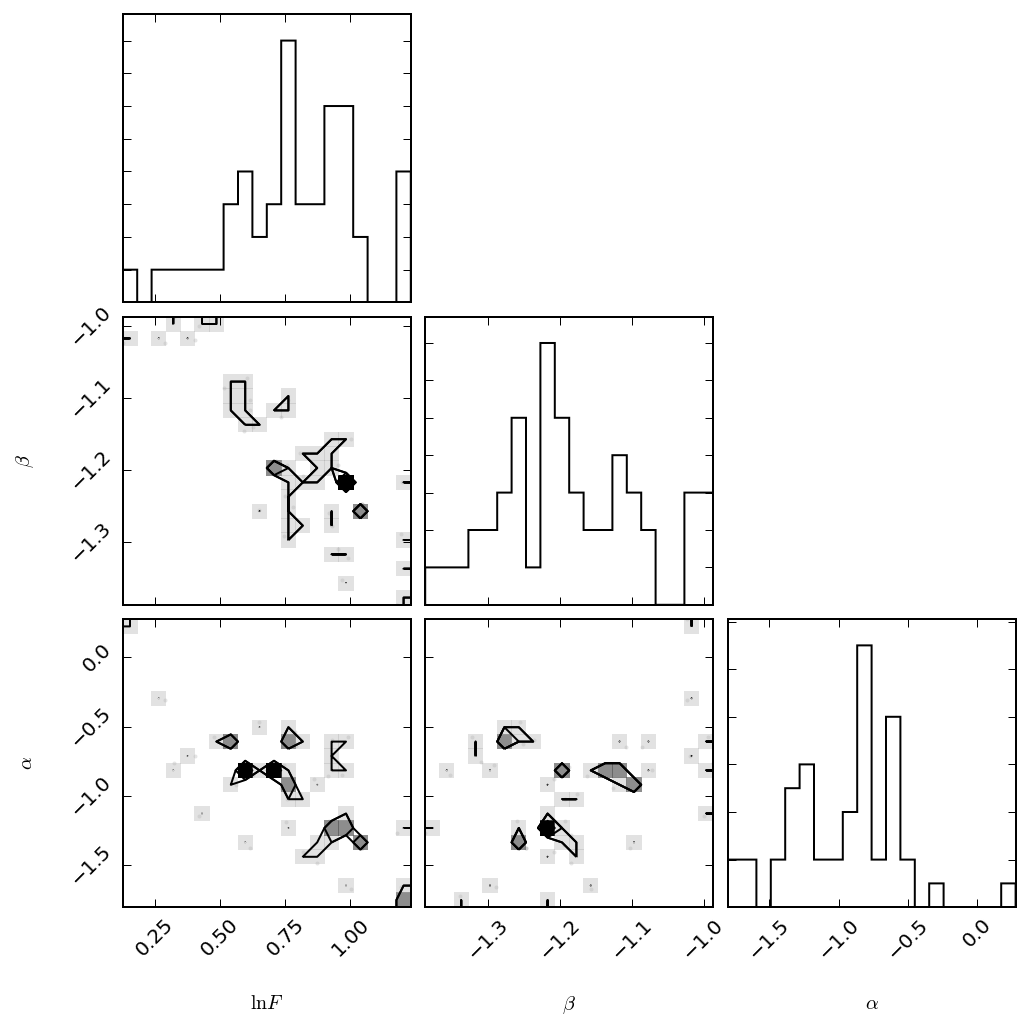

In [252]:
corner.corner(np.hstack((lnf0.reshape(-1,1), beta.reshape(-1,1), alpha.reshape(-1,1))), labels=[r"$\ln F$", r"$\beta$", r"$\alpha$"]);
#corner.corner(np.hstack((beta.reshape(-1,1), alpha.reshape(-1,1))), labels=[r"$\beta$", r"$\alpha$"]);


print(alpha.shape)